# Large Scale Linear Programming Optimization

This notebook supplements SIMT ITS Analytics Projects lecture on Prescriptive Analytics Case Studies Overview by [Mansur M. Arief](https://mansurarief.github.io/).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/analytics-project-simt-its/analytics-project-simt-its.github.io/blob/main/notebooks/pyomo_linear_programming.ipynb)


In this notebook, we will show how to solve optimization problems using `pyomo` and `gurobi` solver. This is an introductory notebook before we move to more advanced topics such as stochastic optimization and robust optimization. You will need to have [pyomo](https://pyomo.readthedocs.io/en/stable/installation.html) and [gurobi](https://support.gurobi.com/hc/en-us/articles/360044290292-How-do-I-install-Gurobi-for-Python) installed in your system to follow along with this notebook. Note that gurobi is a commercial solver, but it has [a free academic license](https://www.gurobi.com/academia/academic-program-and-licenses/).

## Introduction

Optimization is a mathematical discipline that deals with finding the best solution from all feasible solutions. The best solution is defined by an objective function, which we want to minimize or maximize. The feasible solutions are defined by a set of constraints. In this notebook, we will focus on linear optimization problems, which are optimization problems with linear objective function and linear constraints. In the later notebook, we will add complexity to the problem by considering random parameters, and we will solve the problem using stochastic optimization methods.

To begin, consider this *deterministic* linear optimization problem:

\begin{align*}
\text{minimize}~ \quad & Ax + b \\
\text{s.t.} \quad & Cx \leq D \\
& x \in \mathbb{R}^n
\end{align*}

where $b$ is known constants, and $A, C$ and $D$ are known matrices. Note that the objective function is linear, and the constraints are linear. The feasible set is defined by the set of $x$ that satisfy the constraints, which is a *polyhedron*. A polyhedron is a set of points defined by a set of linear inequalities, which in 2D is simply a polygon.

## Problem Example

For concreteness, let's assume a 2D problem, i.e. $n=2$, with the following parameters: $A=\begin{bmatrix}1 & 2\end{bmatrix}$, $b=-1$, $C=\begin{bmatrix}-1 & -2 \\ -2 & 1 \\ 0 & -1 \\ 2 & 1\end{bmatrix}$, and $D=\begin{bmatrix}8\\1\\-1\\20\end{bmatrix}$. Let's store these parameters in a dictionary for later use.

In [1]:
# Given data
num_vars = 2
num_constraints = 4

A = {1: 1, 2: 2}
b = -1
C = {
    (1, 1): -1, (1, 2): 2,
    (2, 1): -2, (2, 2): 1,
    (3, 1): 0, (3, 2): -1,
    (4, 1): 2, (4, 2): 1
}
D = {1: 8, 2: 1, 3: -1, 4: 20}


# Model parameters for pyomo instance later
model_params = {
    None: {
        'A': A,
        'b': {None: b},
        'C': C,
        'D': D
    }
}

The full problem is therefore as follows:

\begin{align*}
\text{minimize}~ \quad & x_1 + 2x_2 - 1 \\
\text{s.t.} \quad & -x_1 - 2x_2 \leq 8 \\
& -2x_1 + x_2 \leq 1 \\
& -x_2 \leq -1 \\
& 2x_1 + x_2 \leq 20 \\
& x_1, x_2 \in \mathbb{R}
\end{align*}


The feasible set is the intersection of the half-planes defined by the constraints, shown in the figure below. Note that the following code is not part of the optimization problem, but it is used for visualization purposes.

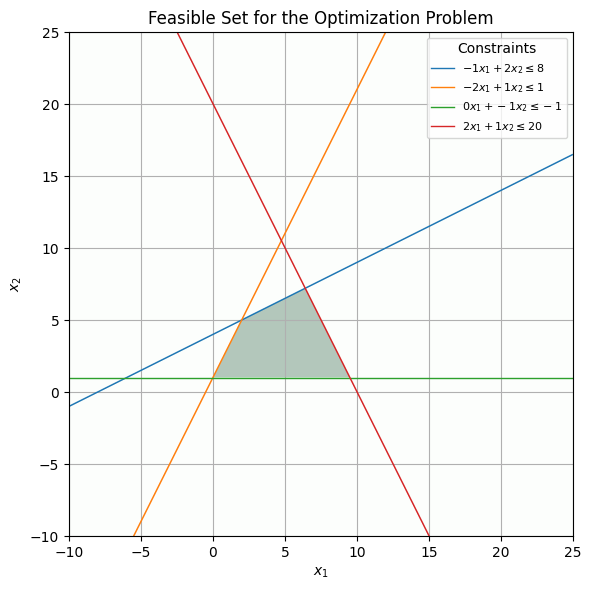

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_constraints_and_feasible_set(C, D):

    x1_range = np.linspace(-10, 25, 900)
    x2_range = np.linspace(-10, 25, 900)
    X1, X2 = np.meshgrid(x1_range, x2_range)

    fig  = plt.figure(figsize=(8, 6))
    feasible_region = None
    custom_lines = []
    labels = []
    colors = [f"C{i}" for i in range(len(D))]

    for j in range(1, len(D) + 1):
        # Construct each constraint based on C and D
        constraint = (C[(j, 1)]*X1 + C[(j, 2)]*X2) - D[j] <= 0
        label = f'${C[(j, 1)]}x_1 + {C[(j, 2)]}x_2 \leq {D[j]}$'
        labels.append(label)

        # Initialize feasible_region or combine with existing
        if feasible_region is None:
            feasible_region = constraint
        else:
            feasible_region &= constraint

        # Plot each constraint line
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="No contour levels were found within the data range.")
            plt.contour(X1, X2, constraint, levels=[0], linestyles='solid', linewidths=1, colors=colors[j-1])

        # Add a custom line object for each constraint
        custom_lines.append(Line2D([0], [0], color=colors[j-1], linewidth=1, linestyle='solid'))

    # Plot feasible region
    plt.imshow(feasible_region.astype(int),
               extent=(x1_range.min(), x1_range.max(), x2_range.min(), x2_range.max()),
               origin="lower", cmap="Greens", alpha=0.3)

    plt.title('Feasible Set for the Optimization Problem')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.grid(True)
    plt.xlim([-10, 25])
    plt.ylim([-10, 25])

    # Create legend
    plt.legend(custom_lines, labels, loc='upper right', title="Constraints", fontsize=8)

    plt.tight_layout()
    plt.show()
    # fig.savefig('temp.png', transparent=True)

def plot_feasible_set_and_objective(C, D, A, b, f_star=None, x_star=None):
    x1_range = np.linspace(-10, 25, 900)
    x2_range = np.linspace(-10, 25, 900)
    X1, X2 = np.meshgrid(x1_range, x2_range)

    fig = plt.figure(figsize=(8, 6))
    feasible_region = None
    custom_lines = []
    labels = []
    colors = [f"C{i}" for i in range(len(D))]

    # Plot constraints
    for j in range(1, len(D) + 1):
        constraint = (C[(j, 1)]*X1 + C[(j, 2)]*X2) - D[j] <= 0
        label = f'${C[(j, 1)]}x_1 + {C[(j, 2)]}x_2 \leq {D[j]}$'
        labels.append(label)

        if feasible_region is None:
            feasible_region = constraint
        else:
            feasible_region &= constraint

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plt.contour(X1, X2, constraint, levels=[0], linestyles='solid', linewidths=1, colors=colors[j-1])

        custom_lines.append(Line2D([0], [0], color=colors[j-1], linewidth=1, linestyle='solid'))

    # Plot feasible region
    plt.imshow(feasible_region.astype(int),
               extent=(x1_range.min(), x1_range.max(), x2_range.min(), x2_range.max()),
               origin="lower", cmap="Greens", alpha=0.3)

    # Plot objective function isovalue contours
    Z = A[1]*X1 + A[2]*X2 + b
    if f_star is not None:
        CS = plt.contour(X1, X2, Z, 50, alpha=0.5, levels=[f_star], colors='k')
        plt.clabel(CS, inline=True, fontsize=8, fmt='%1.1f', colors='k')

    # Mark the optimal solution x_star if provided
    if x_star is not None:
        plt.plot(x_star[0], x_star[1], 'k*', markersize=10, label='$x^*$')

    plt.title('Feasible Set and Objective Isovalues')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.grid(True)
    plt.xlim([-10, 25])
    plt.ylim([-10, 25])

    # Extend the legend with the optimal solution marker
    if x_star is not None:
        custom_lines.append(Line2D([0], [0], color='k', marker='*', linestyle='None', markersize=10))
        labels.append('$x^*$')

    plt.legend(custom_lines, labels, loc='upper right', title="Constraints & Solution", fontsize=8)

    plt.tight_layout()
    plt.show()

#from utils import plot_feasible_set_and_objective

plot_constraints_and_feasible_set(C, D)

It is clear that the feasible set is bounded, so we can find the optimal solution by solving the problem. Let's use the `pyomo` library to solve this problem.

## Model Formulation in Pyomo

We begin by importing the necessary libraries. Then, we define the sets and parameters $A$, $b$, $C$, and $D$. We also define the model and the decision variables $x$.

In [3]:
#install pyomo and gurobi

%pip install pyomo
%pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 30.2 MB/s eta 0:00:00


In [38]:
from pyomo.environ import AbstractModel, Var, Param, Objective, Constraint, SolverFactory, minimize, RangeSet, value, Reals, SolverStatus, TerminationCondition, Binary

# Define the abstract model
model = AbstractModel()

# Declare index sets for variables and constraints
model.I = RangeSet(1, num_vars)  # Index set for variables
model.J = RangeSet(1, num_constraints)  # Index set for constraints

# Declare parameters
model.A = Param(model.I, within=Reals)
model.b = Param(within=Reals)
model.C = Param(model.J, model.I, within=Reals)
model.D = Param(model.J, within=Reals)

# Declare model variables with correct domain
model.x = Var(model.I, domain=Reals)

Finally, we define the objective function and the constraints.

In [5]:
# Objective function
def objective_rule(model):
    return sum(model.A[i] * model.x[i] for i in model.I) + model.b
model.obj = Objective(rule=objective_rule, sense=minimize)

# Constraints
def constraint_rule(model, j):
    return sum(model.C[j, i] * model.x[i] for i in model.I)  <= model.D[j]
model.constraint = Constraint(model.J, rule=constraint_rule)

Note here that we use the `AbstractModel` class to define the model. This allows us to define the model without specifying the values, just yet. This is useful when we want to solve the same problem with different parameters, or when we want to solve the problem with random parameters.

We then create an instance of the model by passing the values of the parameters we stored earlier.

In [6]:
# Create a concrete instance of the model
instance = model.create_instance(model_params)

## Solving the Model

Now, that the problem instance is created, we can solve the problem using the `gurobi` solver. You may use other solvers such as `cplex` or `glpk` by changing the solver name. You also need to find the path to the solver executable, and set the path in the `solver` object.

In [7]:
# Solve the concrete instance of the model
solver = SolverFactory('gurobi') #change the path to the gurobi.sh file in your system
result = solver.solve(instance, tee=True)

Restricted license - for non-production use only - expires 2025-11-24
Read LP format model from file /tmp/tmp433gk112.pyomo.lp
Reading time = 0.02 seconds
x1: 4 rows, 3 columns, 7 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 4 rows, 3 columns and 7 nonzeros
Model fingerprint: 0xbdfc69b1
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 4 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.000000000e+00


Also, it is a good practice to check the status of the solution. If the status is `optimal`, then the solution is valid. Otherwise, the solution may not be valid.

In [8]:
# Print the results
if result.solver.status == SolverStatus.ok and result.solver.termination_condition == TerminationCondition.optimal:
    x_optimal = {i: value(instance.x[i]) for i in instance.I}
    optimal_value = instance.obj()
    print(f'Optimal solution: {x_optimal}, optimal value: {optimal_value}')
else:
    print('Solver status:', result.solver.status)
    print('Termination condition:', result.solver.termination_condition)

Optimal solution: {1: 0.0, 2: 1.0}, optimal value: 1.0


## Extracting the Solution

Now that we have the solution, we can extract the optimal solution and the optimal value of the objective function. Finally, we can visualize the solution by plotting the feasible set and the optimal solution. The optimal solution is the point where the objective function is minimized, and it is the point where the objective function is tangent to the feasible set.

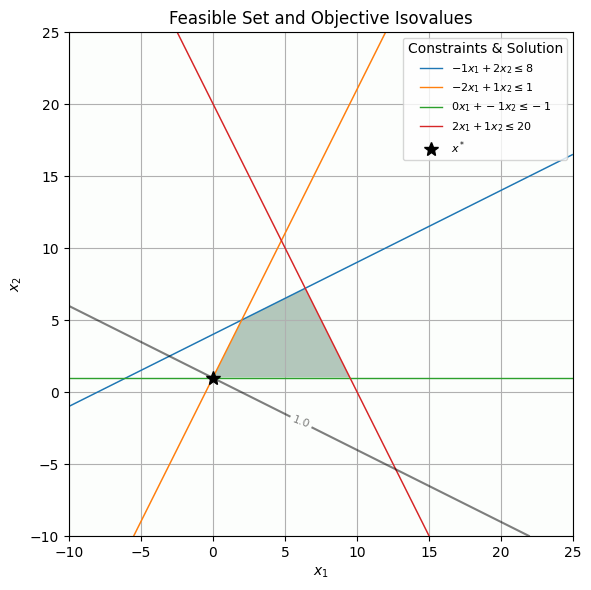

In [9]:
#from utils import plot_feasible_set_and_objective

x_star = [x_optimal[i] for i in instance.I]
f_star = optimal_value

plot_feasible_set_and_objective(C, D, A, b, f_star, x_star)

## Concluding Remarks

A couple of concluding remarks here:

- You can easily load the parameters from a file, or from a database, or from a web service. This is useful when you want to solve the same problem with different parameters.
- You can also use the `pyomo` library to solve more complex problems, such as mixed-integer linear programming (MILP), quadratic programming (QP), and nonlinear programming (NLP).
- You can also use the `pyomo` library to solve problems with random parameters, and you can use the `gurobi` solver to solve stochastic optimization problems. In the next notebook, we will show how to solve stochastic optimization problems using simulation-based method and polytope-based method.


The full notebook with the visualization code and practice set included is available here.

In [74]:
import pandas as pd
M = 25
df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv")[:M]

In [75]:
df

,City,State,Population,lat,lon
0,Marysville,Washington,63269,48.051764,-122.177082
1,Perris,California,72326,33.782519,-117.228648
2,Cleveland,Ohio,390113,41.499320,-81.694361
3,Worcester,Massachusetts,182544,42.262593,-71.802293
4,Columbia,South Carolina,133358,34.000710,-81.034814
5,Waterbury,Connecticut,109676,41.558153,-73.051496
6,Eagan,Minnesota,65453,44.804132,-93.166886
7,Southfield,Michigan,73006,42.473369,-83.221873
8,Lafayette,Louisiana,124276,30.224090,-92.019843
9,Boise City,Idaho,214237,43.618710,-116.214607


In [76]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_us_airport_traffic.csv')

df['text'] = df['City'] + ' (' + df['Population'].astype(str) + ')'

fig = go.Figure(data=go.Scattergeo(
        lon = df['lon'],
        lat = df['lat'],
        text = df['text'],
        mode = 'markers',
        marker_color = df['Population'],
        ))

fig.update_layout(
        title = 'Cities in the USA<br>(Hover for city names)',
        geo_scope='usa',
    )
fig.show()

In [77]:
def vectorized_distance_matrix(lats, lons):
    # Convert latitude and longitude to Cartesian coordinates for Euclidean distance calculation
    # Earth's radius in kilometers (approx)
    R = 6371.0
    x = R * np.cos(np.radians(lats)) * np.cos(np.radians(lons))
    y = R * np.cos(np.radians(lats)) * np.sin(np.radians(lons))
    z = R * np.sin(np.radians(lats))

    # Stack coordinates in a matrix
    coords = np.column_stack((x, y, z))

    # Calculate pairwise distance matrix using broadcasting
    dist_matrix = np.sqrt(np.sum((coords[:, np.newaxis, :] - coords[np.newaxis, :, :]) ** 2, axis=-1))
    return dist_matrix

## Simple optimization problem

Goal: locate facilities to cover all population and minimize the distance from each facilities to assigned cities and facility installation cost

We have $M$ cities.

Parameters:
- $Capacity$: 15,000,000
- $Cost$: 100,000,000
- $d_{ij}$: Distance from city $i$ to city $j$
- $Population_i$: Population in city $i$

Decision variables:
- $x_i$: binary variable (1=locate a facility in city $i$, 0=else)
- $y_{ij}$: binary variable (1=facility in city $i$ is assigned to cover city $j$, 0=else)

Objective function: $$\text{minimize}_{x, y} \sum_{i=1}^M c_i x_i + \sum_{i=1}^M \sum_{j=1}^M y_{ij} d_{ij}$$

Constraint:
- Each facility has capacity:  $$\sum_j y_{ij}Population_j \leq Capacity \cdot x_i, ~ \forall i$$

- All population is served: $$Population_i \leq \sum_{j} Capacity \cdot y_{ij}, \forall i$$

- Assignment happens only if facilities opened: $$y_{ij} \leq x_i, \forall i, \forall j$$

- Binary $x$ variable: $x_i \in \{0, 1\}, \forall i$

- Binary $y$ variable: $y_{ij} \in \{0, 1 \}, \forall i, \forall j$

In [108]:
# M = 100
capacity = 1500000
cost = 100000000
d = vectorized_distance_matrix(df['lat'], df['lon'])
population = df["Population"].values

In [109]:
d.shape

(25, 25)

Build `pyomo` model

In [110]:
# Define the abstract model
model = AbstractModel()

# Parameters
model.M = Param(default=M)
model.Capacity = Param(default=capacity)
model.Cost = Param(default=cost)

# Sets based on parameter M
model.I = RangeSet(1, model.M)
model.J = RangeSet(1, model.M)

# Parameters for distances and populations
model.d = Param(model.I, model.J, initialize=lambda model, i, j: d[i-1][j-1])
model.population = Param(model.I, initialize=lambda model, i: population[i-1])

# Decision Variables
model.x = Var(model.I, domain=Binary)
model.y = Var(model.I, model.J, domain=Binary)


In [111]:
def objective_rule(model):
    return sum(model.Cost * model.x[i] for i in model.I) + sum(sum(model.y[i,j] * model.d[i,j] for j in model.J) for i in model.I)
model.Objective = Objective(rule=objective_rule, sense=minimize)


In [112]:
# Each facility has a maximum capacity
def capacity_constraint_rule(model, i):
    return sum(model.y[i,j] * model.population[j] for j in model.J) <= model.Capacity * model.x[i]
model.CapacityConstraint = Constraint(model.I, rule=capacity_constraint_rule)

# Ensure all population is covered
def population_coverage_rule(model, i):
    return model.population[i] <= sum(model.y[j,i] * model.Capacity for j in model.I)
model.PopulationCoverage = Constraint(model.I, rule=population_coverage_rule)

# Assignment only if facility is opened
def assignment_rule(model, i, j):
    return model.y[i,j] <= model.x[i]
model.AssignmentConstraint = Constraint(model.I, model.J, rule=assignment_rule)


In [113]:
# Create a model
instance = model.create_instance()
solver = SolverFactory('gurobi') #can change with glpk, coin-or, etc.

In [114]:
results = solver.solve(instance, tee=True)

Restricted license - for non-production use only - expires 2025-11-24
Read LP format model from file /tmp/tmpmy5p1zr2.pyomo.lp
Reading time = 0.00 seconds
x1: 675 rows, 650 columns, 2525 nonzeros
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 675 rows, 650 columns and 2525 nonzeros
Model fingerprint: 0xbd8d4616
Variable types: 0 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+06]
  Objective range  [1e+01, 1e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+04, 4e+05]
Found heuristic solution: objective 1.500045e+09
Presolve time: 0.01s
Presolved: 675 rows, 650 columns, 2525 nonzeros
Variable types: 0 continuous, 650 integer (650 binary)
Found heuristic solution: objective 1.500021e+09

Root relaxation: objective 1.955989e+08

In [115]:
# Print the results

x_optimal = {i: value(instance.x[i]) for i in instance.I}
y_optimal = {(i, j): value(instance.y[i, j]) for i in instance.I for j in instance.J}


In [116]:
facility_locations = [i for i in instance.I if value(instance.x[i]) > 0.5]

# Determine the lines from facilities to assigned cities
lines = []
for i in facility_locations:
    for j in instance.J:
        if value(instance.y[i, j]) > 0.5:
            lines.append((i, j))

In [117]:
fig = go.Figure()

# Plot all cities
fig.add_trace(go.Scattergeo(
    lon = df['lon'],
    lat = df['lat'],
    text = df['text'],
    mode = 'markers',
    marker = dict(
        size = 8,
        color = 'blue',
        line = dict(width = 1, color = 'rgba(102, 102, 102)'),
    ),
    name = 'Cities'
))

# Highlight facilities
fig.add_trace(go.Scattergeo(
    lon = [df.loc[i-1, 'lon'] for i in facility_locations],
    lat = [df.loc[i-1, 'lat'] for i in facility_locations],
    text = [df.loc[i-1, 'text'] for i in facility_locations],
    mode = 'markers',
    marker = dict(
        size = 15,
        color = 'red',
        line = dict(width = 1, color = 'rgba(102, 102, 102)'),
    ),
    name = 'Facilities'
))

# Add lines connecting facilities to their assigned cities
for line in lines:
    i, j = line
    fig.add_trace(
        go.Scattergeo(
            lon = [df.loc[i-1, 'lon'], df.loc[j-1, 'lon']],
            lat = [df.loc[i-1, 'lat'], df.loc[j-1, 'lat']],
            mode = 'lines',
            line = dict(width = 2, color = 'red'),
            opacity = 0.6
        )
    )

# Update layout
fig.update_layout(
    title_text = 'Optimal Facility Locations and Assignments',
    showlegend = False,
    geo = dict(
        scope = 'usa',
        projection_type = 'albers usa',
        showland = True,
        landcolor = 'rgb(217, 217, 217)',
        subunitwidth = 1,
        countrywidth = 1,
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)"
    ),
)

fig.show()


### Remark

Note that here we solve for smaller set of the cities, because free gurobi license limits the problem size, but you can always get free academic license while being a student at SIMT. Here is the full scale problem (can be solved using your academic license).

In [120]:
SOLVE_FULL_SCALE = False
import gurobipy as gp

if SOLVE_FULL_SCALE:

  params = {
    "WLSACCESSID": 'XXXXXX',
    "WLSSECRET": 'XXXXXX',
    "LICENSEID": 000000,
  }
  env = gp.Env(params=params)

  df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv")
  M = 1000
  capacity = 15000000
  cost = 100000000
  d = vectorized_distance_matrix(df['lat'], df['lon'])
  population = df["Population"].values


  # Define the model
  model = AbstractModel(env=env)
  model.M = Param(default=M)
  model.Capacity = Param(default=capacity)
  model.Cost = Param(default=cost)

  model.I = RangeSet(1, model.M)
  model.J = RangeSet(1, model.M)

  model.d = Param(model.I, model.J, initialize=lambda model, i, j: d[i-1][j-1])
  model.population = Param(model.I, initialize=lambda model, i: population[i-1])

  model.x = Var(model.I, domain=Binary)
  model.y = Var(model.I, model.J, domain=Binary)

  # Instantiate
  instance = model.create_instance()
  solver = SolverFactory('gurobi')

  # Solve
  results = solver.solve(instance, tee=True)

  # Extract results
  facility_locations = [i for i in instance.I if value(instance.x[i]) > 0.5]
  lines = []
  for i in facility_locations:
      for j in instance.J:
          if value(instance.y[i, j]) > 0.5:
              lines.append((i, j))


  # Plot
  fig = go.Figure()
  fig.add_trace(go.Scattergeo(
      lon = df['lon'],
      lat = df['lat'],
      text = df['text'],
      mode = 'markers',
      marker = dict(
          size = 8,
          color = 'blue',
          line = dict(width = 1, color = 'rgba(102, 102, 102)'),
      ),
      name = 'Cities'
  ))
  fig.add_trace(go.Scattergeo(
      lon = [df.loc[i-1, 'lon'] for i in facility_locations],
      lat = [df.loc[i-1, 'lat'] for i in facility_locations],
      text = [df.loc[i-1, 'text'] for i in facility_locations],
      mode = 'markers',
      marker = dict(
          size = 15,
          color = 'red',
          line = dict(width = 1, color = 'rgba(102, 102, 102)'),
      ),
      name = 'Facilities'
  ))
  for line in lines:
      i, j = line
      fig.add_trace(
          go.Scattergeo(
              lon = [df.loc[i-1, 'lon'], df.loc[j-1, 'lon']],
              lat = [df.loc[i-1, 'lat'], df.loc[j-1, 'lat']],
              mode = 'lines',
              line = dict(width = 2, color = 'red'),
              opacity = 0.6
          )
      )
  fig.update_layout(
      title_text = 'Optimal Facility Locations and Assignments',
      showlegend = False,
      geo = dict(
          scope = 'usa',
          projection_type = 'albers usa',
          showland = True,
          landcolor = 'rgb(217, 217, 217)',
          subunitwidth = 1,
          countrywidth = 1,
          subunitcolor = "rgb(255, 255, 255)",
          countrycolor = "rgb(255, 255, 255)"
      ),
  )

  fig.show()